**Descriptions (from source):** <br>
- **Age**: age of the patient [years]
- **Sex**: sex of the patient [M: Male, F: Female]
- **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- **RestingBP**: resting blood pressure [mm Hg]
- **Cholesterol**: serum cholesterol [mm/dl]
- **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
- **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
- **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- **HeartDisease**: output class [1: heart disease, 0: Normal]

**Descriptions (new):** <br>
- **Sex**: sex of the patient [0: Female, 1: Male]
- **ChestPainType**: chest pain type [0: Asymptomatic, 1: Atypical Angina, 2: Non-Anginal Pain, 3: Typical Angina]
- **RestingECG**: resting electrocardiogram results [0: showing probable or definite left ventricular hypertrophy by Estes' criteria, 1: Normal, 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)]
- **ExerciseAngina**: exercise-induced angina [0: No, 1: Yes]
- **ST_Slope**: the slope of the peak exercise ST segment [0: downsloping, 1: flat, 2: upsloping]

In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Load the saved datasets from previous step
heart = pd.read_csv('heart_preprocessing.csv', index_col=0)

In [3]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,1,1,1,0.462965,0.848073,0,1,1.389073,0,0.317073,2,0
1,2,0,2,1.627615,-0.169617,0,1,0.756166,0,0.439024,1,1
2,0,1,1,-0.119361,0.792053,0,2,-1.538120,0,0.317073,2,0
3,1,0,0,0.346500,0.147828,0,1,-1.142554,1,0.500000,1,1
4,2,1,2,1.045290,-0.029568,0,1,-0.588760,0,0.317073,2,0


Remember we will also exclude 'RestingECG' and 'RestingBP' in Preprocessing

In [4]:
# Split train and test again with 80% to 20% ratio
X = heart.drop(['HeartDisease', 'RestingBP', 'RestingECG'],
              axis=1).values
y = heart['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=123)

In [5]:
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)

(905, 9) (905,)
(724, 9) (724,)


Since it is a classification problem (predicting whether the patients will have heart diseases), I will include the following models:
- K-Nearest Neighbor (KNN)
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- Naive Bayes
- Gradient Boosting

# Train the models

In [6]:
# Import all model packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

In [7]:
# Build a pipeline to fit all models
# We use default parameters for all models at first
model_pipe = [] # create an empty list to store all models

model_pipe.append(KNeighborsClassifier()) # knn
model_pipe.append(LogisticRegression(solver='liblinear')) # logistic regression
model_pipe.append(RandomForestClassifier()) # random forest
model_pipe.append(SVC()) # svc
model_pipe.append(GaussianNB()) # naive bayes
model_pipe.append(GradientBoostingClassifier()) # gradient boosting

In [8]:
# Build a pipeline for model evaluation
# We will use Accuracy, Cross-Validation, AUC, and Confusion Matrix

acc_score = []
cv_score = []
auc_score = []
cm_score = []

for model in model_pipe:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))
    kf = KFold(n_splits=6, shuffle=True, random_state=123)
    cv_score.append(np.mean(cross_val_score(model,X_train,y_train, cv=kf)))
    auc_score.append(roc_auc_score(y_test, y_pred))
    cm_score.append(confusion_matrix(y_test, y_pred))

In [9]:
# Train the model to get ROC and AUC results
table = pd.DataFrame(columns=['classifiers','fpr','tpr','auc'])

for m in model_pipe:
    model = m.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, ypred)
    auc = roc_auc_score(y_test, ypred)
    
    table = table.append({'classifiers': m.__class__.__name__,
                        'fpr': fpr,
                        'tpr': tpr,
                        'auc': auc}, ignore_index=True)
    
table.set_index('classifiers', inplace=True)

/var/folders/5r/zswwxscs1fg2xzmhnbhxqjx00000gn/T/ipykernel_17632/134960289.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'classifiers': m.__class__.__name__,
/var/folders/5r/zswwxscs1fg2xzmhnbhxqjx00000gn/T/ipykernel_17632/134960289.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'classifiers': m.__class__.__name__,
/var/folders/5r/zswwxscs1fg2xzmhnbhxqjx00000gn/T/ipykernel_17632/134960289.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'classifiers': m.__class__.__name__,
/var/folders/5r/zswwxscs1fg2xzmhnbhxqjx00000gn/T/ipykernel_17632/134960289.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

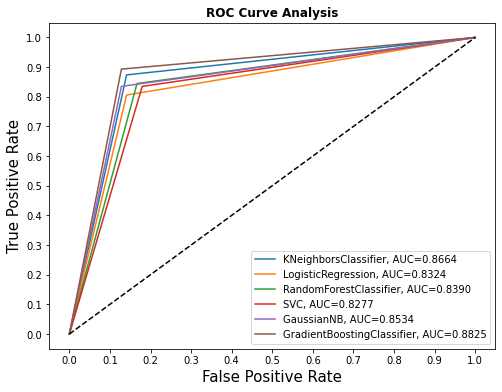

In [10]:
# Plot ROC curves
fig = plt.figure(figsize=(8,6))

for i in table.index:
    plt.plot(table.loc[i]['fpr'],
            table.loc[i]['tpr'],
            label='{}, AUC={:.4f}'.format(i, table.loc[i]['auc']))
plt.plot([0,1],[0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('False Positive Rate', fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive Rate', fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold')
plt.legend(loc='lower right')

plt.show()

In [11]:
# Now we can see how each model performs
model_list = ['KNN', 'Logistic Regression', 'Random Forest',
             'SVC', 'Naive Bayes', 'Gradient Boosting']
evaluation_df = pd.DataFrame({'Model': model_list, 
                              'Accuracy': acc_score,
                              'CV': cv_score,
                             'AUC': auc_score})
evaluation_df

,Model,Accuracy,CV,AUC
0,KNN,0.867403,0.838361,0.866380
1,Logistic Regression,0.828729,0.850849,0.832400
2,Random Forest,0.850829,0.856348,0.850261
3,SVC,0.828729,0.860491,0.827732
4,Naive Bayes,0.850829,0.861869,0.853373
5,Gradient Boosting,0.883978,0.861857,0.882499


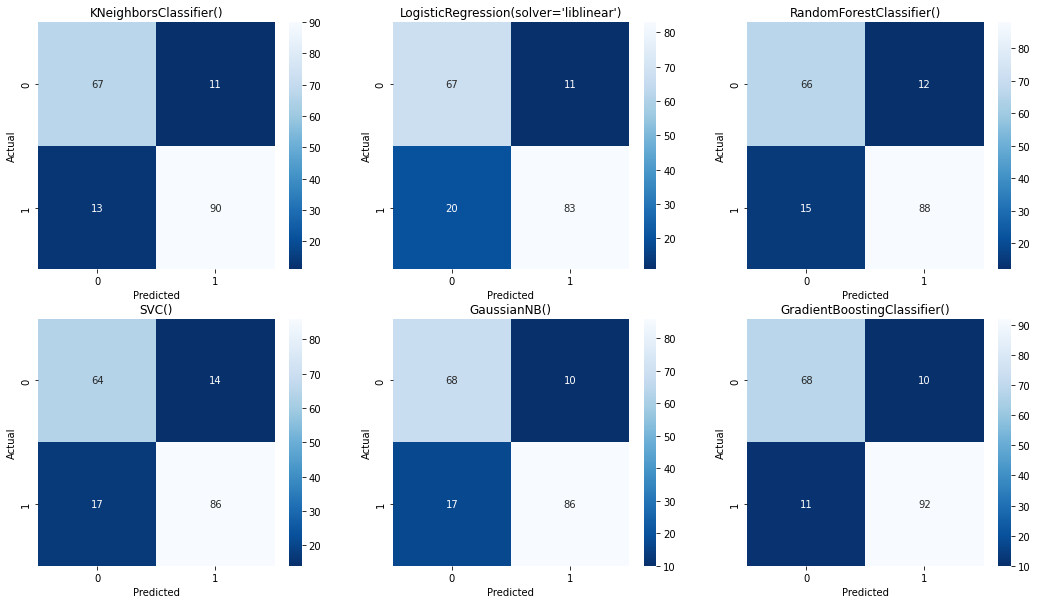

In [12]:
# Now we create a confusion matrix for the results
fig = plt.figure(figsize=(18,10))

for i in range(len(cm_score)):
    cm = cm_score[i]
    model = model_pipe[i]
    sub = fig.add_subplot(2,3,i+1).set_title(model)
    _ = sns.heatmap(cm, annot=True,cmap='Blues_r')
    _.set_xlabel('Predicted')
    _.set_ylabel('Actual')

From the above evaluations, we can notice that the Gradient Boosting has the highest accuracy score and AUC score, followed by KNN. Logistic Regression and SVC seem to be not doing well. 
On the other hand, Random Forest has the highest Cross validation score, followed by Gradient Boosting.
But remember we only train each model with its default parameters, model performance might be different if applying different parameters. So, the next step is hyperparameter tuning. 

# Hyperparameter Tuning

### Random Forest

In [14]:
# Apply Gridsearch CV for Random Forest
rf = RandomForestClassifier(random_state=123)
params = {'n_estimators': [100, 500],
             'max_depth': [4,5,6,7,8],
             'criterion': ['gini','entropy'],
         'min_samples_leaf': [1,5,10]}
cv_rf = GridSearchCV(estimator=rf, param_grid=params, cv=5)
cv_rf.fit(X_train, y_train)

print(cv_rf.best_estimator_)
print(cv_rf.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=500,
                       random_state=123)
0.879837164750958


In [29]:
# Train our data with optimized random forest model
rf = RandomForestClassifier(criterion = 'entropy',
                           max_depth = 7,
                           n_estimators=500,
                           random_state=123)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

# Accuracy score
acc = round(accuracy_score(y_test, ypred),4)
# CV score
cv = round(cross_val_score(rf, X_test, y_test, scoring = 'roc_auc').mean(),4)
# ROC-AUC score
rf_optimized_y = rf.predict_proba(X_test)[:,1]
rf_optimized_auc = round(roc_auc_score(y_test, rf_optimized_y),4)

print(f'Accuracy score for optimized random forest model: {acc}')
print(f'Cross validation score for optimized random forest model: {cv}')
print(f'AUC score for optimized random forest model: {rf_optimized_auc}')

Accuracy score for optimized random forest model: 0.8619
Cross validation score for optimized random forest model: 0.9235
AUC score for optimized random forest model: 0.9349


In [23]:
# Feature importance of optimized random forest
names = list((heart.drop(['HeartDisease', 'RestingBP', 'RestingECG'],
              axis=1)).columns)
importance = np.sort(list(rf.feature_importances_))
importance_df = pd.DataFrame({'Features': names,
                             'Importance scores': importance})
importance_df

,Features,Importance scores
0,Age,0.033472
1,Sex,0.037355
2,ChestPainType,0.037526
3,Cholesterol,0.103112
4,FastingBS,0.121984
5,MaxHR,0.123753
6,ExerciseAngina,0.124364
7,Oldpeak,0.126131
8,ST_Slope,0.292303


Based on optimized random forest model, 'St_Slope' is the most important feature predicting heart diseases.

### Gradient Boost

In [36]:
# Apply Gridsearch CV for Gradient Boost
gb = GradientBoostingClassifier(random_state=123)
params = {'n_estimators': [100, 200, 300],
          'learning_rate': [0.1, 0.05, 0.01],
         'min_samples_leaf':[100,150],
         'max_depth': [4,8]}
cv_gb = GridSearchCV(estimator=gb, param_grid=params, cv=5)
cv_gb.fit(X_train, y_train)

print(cv_gb.best_estimator_)
print(cv_gb.best_score_)

GradientBoostingClassifier(max_depth=4, min_samples_leaf=100, random_state=123)
0.8770785440613027


In [48]:
# Train our data with optimized gradient boosting model
gb = GradientBoostingClassifier(max_depth=4,
                               min_samples_leaf=100,
                               random_state=123)
gb.fit(X_train, y_train)
ypred = gb.predict(X_test)

# Accuracy score
acc = round(accuracy_score(y_test, ypred),4)
# CV score
cv = round(cross_val_score(gb, X_test, y_test, scoring = 'roc_auc').mean(),4)
# ROC-AUC score
gb_optimized_y = gb.predict_proba(X_test)[:,1]
gb_optimized_auc = round(roc_auc_score(y_test, gb_optimized_y),4)

print(f'Accuracy score for optimized gradient boosting model: {acc}')
print(f'Cross validation score for optimized gradient boosting model: {cv}')
print(f'AUC score for optimized gradient boosting model: {rf_optimized_auc}')

Accuracy score for optimized gradient boosting model: 0.8564
Cross validation score for optimized gradient boosting model: 0.5
AUC score for optimized gradient boosting model: 0.9349


In [38]:
# Feature importance of optimized gradient boosting
names = list((heart.drop(['HeartDisease', 'RestingBP', 'RestingECG'],
              axis=1)).columns)
importance = np.sort(list(gb.feature_importances_))
importance_df = pd.DataFrame({'Features': names,
                             'Importance scores': importance})
importance_df

,Features,Importance scores
0,Age,0.003179
1,Sex,0.020458
2,ChestPainType,0.031236
3,Cholesterol,0.042262
4,FastingBS,0.061171
5,MaxHR,0.063958
6,ExerciseAngina,0.071845
7,Oldpeak,0.124129
8,ST_Slope,0.581762


Based on optimized gradient boosting model, 'St_Slope' is the most important feature predicting heart diseases.

### KNN

In [43]:
# Apply Gridsearch CV for KNN
knn = KNeighborsClassifier()
params = {
         'n_neighbors': list(range(1, 50)),
         'weights': ['uniform', 'distance'],
         'metric': ['minkowski','euclidean','manhattan']}
cv_knn = GridSearchCV(estimator=knn, param_grid=params, cv=5)
cv_knn.fit(X_train, y_train)

print(cv_knn.best_estimator_)
print(cv_knn.best_score_)

KNeighborsClassifier(metric='manhattan', n_neighbors=15)
0.8687835249042145


In [50]:
# Train our data with optimized KNN model
knn = KNeighborsClassifier(metric='manhattan',
                          n_neighbors=15)
knn.fit(X_train, y_train)
ypred = knn.predict(X_test)

# Accuracy score
acc = round(accuracy_score(y_test, ypred),4)
# CV score
cv = round(cross_val_score(knn, X_test, y_test, scoring = 'roc_auc').mean(),4)
# ROC-AUC score
knn_optimized_y = knn.predict_proba(X_test)[:,1]
knn_optimized_auc = round(roc_auc_score(y_test, knn_optimized_y),4)

print(f'Accuracy score for optimized KNN model: {acc}')
print(f'Cross validation score for KNN model: {cv}')
print(f'AUC score for optimized KNN model: {rf_optimized_auc}')

Accuracy score for optimized KNN model: 0.8785
Cross validation score for KNN model: 0.9229
AUC score for optimized KNN model: 0.9349


# Conclusion

- We have proceeded with the previous step into modeling in this notebook
- Data is split with 80% to 20% ratio for training and testing datasets
- There are 9 predictive features (after feature engineering) and 1 target feature (heart diseases: 0 and 1)
- This is a classification problem and so we used following machine learning models: 
    - K-Nearest Neighbor (KNN)
    - Logistic Regression
    - Random Forest
    - Support Vector Machine (SVM)
    - Naive Bayes
    - Gradient Boosting
- We created a pipeline to train all models and also to get evaluation metrics, namely, Accuracy Score, CV Score, and ROC-AUC Score for model performance
- Next, we have explored hyperparameters tuning to optimize model performance, and we have looked at 3 models specifically, Random Forest, Gradient Boosting, and KNN
- From the results after tuning, the highest accuracy score is KNN (0.8785) and the highest cv score is Random Forest (0.9235)
- It is worth noticiing that Random Forest and Gradient Boosting both agree on the most predicting feature: 'ST_Slope'